In [1]:


# Standard library imports
import warnings

# Data manipulation and visualization libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistics and data preprocessing
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.metrics import (
    pairwise_distances, 
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (
    GridSearchCV, 
    train_test_split, 
    KFold, 
    cross_val_score
)
from mpl_toolkits.mplot3d import Axes3D

# Miscellaneous settings
warnings.filterwarnings('ignore')
%matplotlib inline
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Import CSV files in here


In [8]:
# Import files here;

# Using absolute paths
file_1 = r"C:\Users\kaan\Documents\Thesis Data\Exp_003\EXP_003_Data\Area_CSV_file_test_003_PLA_EthylAce_and_Ethanol_KY_16-04\Area_cm2_multi_roi_test_003_PLA_EthylAce_and_Ethanol_KY_16-04.csv"
file_2 = r"c:\Users\kaan\Documents\Thesis Data\Exp_003\EXP_003_Data\Area_CSV_file_test_003_PLA_EthylAce_and_Ethanol_KY_16-04_PartB\Area_cm2_multi_roi_test_003_PLA_EthylAce_and_Ethanol_KY_16-04_PartB.csv"
file_3 = r"c:\Users\kaan\Documents\Thesis Data\Exp_003\EXP_003_Data\Area_CSV_file_test_003_PLA_EthylAce_and_Ethanol_KY_16-04_PartB-2\Area_cm2_multi_roi_test_003_PLA_EthylAce_and_Ethanol_KY_16-04_PartB-2.csv"

# Read the files
df1 = pd.read_csv(file_1)
df2 = pd.read_csv(file_2)
df3 = pd.read_csv(file_3)

# Check shapes (note: shape is a property, not a method)
print(df1.shape)
print(df2.shape)
print(df3.shape)



(7785, 12)
(130, 12)
(42470, 12)


## Combine all the 3 files together

In [9]:
# Combine files with continuous time
if df1 is not None and df2 is not None and df3 is not None:
    # Get the last elapsed time from each dataframe
    last_time_df1 = df1['elapsed_time'].iloc[-1] if not df1.empty else 0
    last_time_df2 = df2['elapsed_time'].iloc[-1] if not df2.empty else 0
    
    # Adjust the elapsed_time in df2 and df3
    df2['elapsed_time'] = df2['elapsed_time'] + last_time_df1
    df3['elapsed_time'] = df3['elapsed_time'] + last_time_df1 + last_time_df2
    
    # Combine all dataframes
    combined_df = pd.concat([df1, df2, df3], ignore_index=True)
    
    # Display information about the combined dataframe
    print("Combined DataFrame Shape:", combined_df.shape)
    print("\nFirst few rows:")
    print(combined_df.head())
    print("\nLast few rows:")
    print(combined_df.tail())
    
    # Save the combined dataframe to a new CSV file
    output_file = "combined_data.csv"
    combined_df.to_csv(output_file, index=False)
    print(f"\nCombined data saved to {output_file}")
else:
    print("Could not combine files due to missing data")

file = "combined_data.csv"
combined_df = pd.read_csv(file)


Combined DataFrame Shape: (50385, 12)

First few rows:
         timestamp  elapsed_time  PLA_100-EthylAce_0-Ehtanol_pixel_area  \
0  20250416_134409          1.85                               107134.5   
1  20250416_134419         11.87                               107203.0   
2  20250416_134429         21.96                               107305.0   
3  20250416_134440         32.04                               107368.0   
4  20250416_134450         42.13                               107388.0   

   PLA_100-EthylAce_0-Ehtanol_area_cm2  PLA_75-EthylAce_25-Ehtanol_pixel_area  \
0                             3.965857                               105441.0   
1                             3.968393                               105686.0   
2                             3.972169                               105774.5   
3                             3.974501                               105826.0   
4                             3.975241                               105789.5   

   PLA_

## Remove all zeros from an array and outliers


Removed 0 rows where all area columns are 0 (0.00% of data)

Zero values replaced with NaN in each column:
  - PLA_100-EthylAce_0-Ehtanol_area_cm2: 21733 zeros replaced (43.13% of values)
  - PLA_75-EthylAce_25-Ehtanol_area_cm2: 38639 zeros replaced (76.69% of values)
  - PLA_50-EthylAce_50-Ehtanol_area_cm2: 4037 zeros replaced (8.01% of values)
  - PLA_25-EthylAce_75-Ehtanol_area_cm2: 341 zeros replaced (0.68% of values)
  - PLA_0-EthylAce_100-Ehtanol_area_cm2: 58 zeros replaced (0.12% of values)

Total zero values replaced with NaN: 64808

Final data shape after removing zeros and replacing with NaN: (50385, 12)
Removed a total of 0 rows


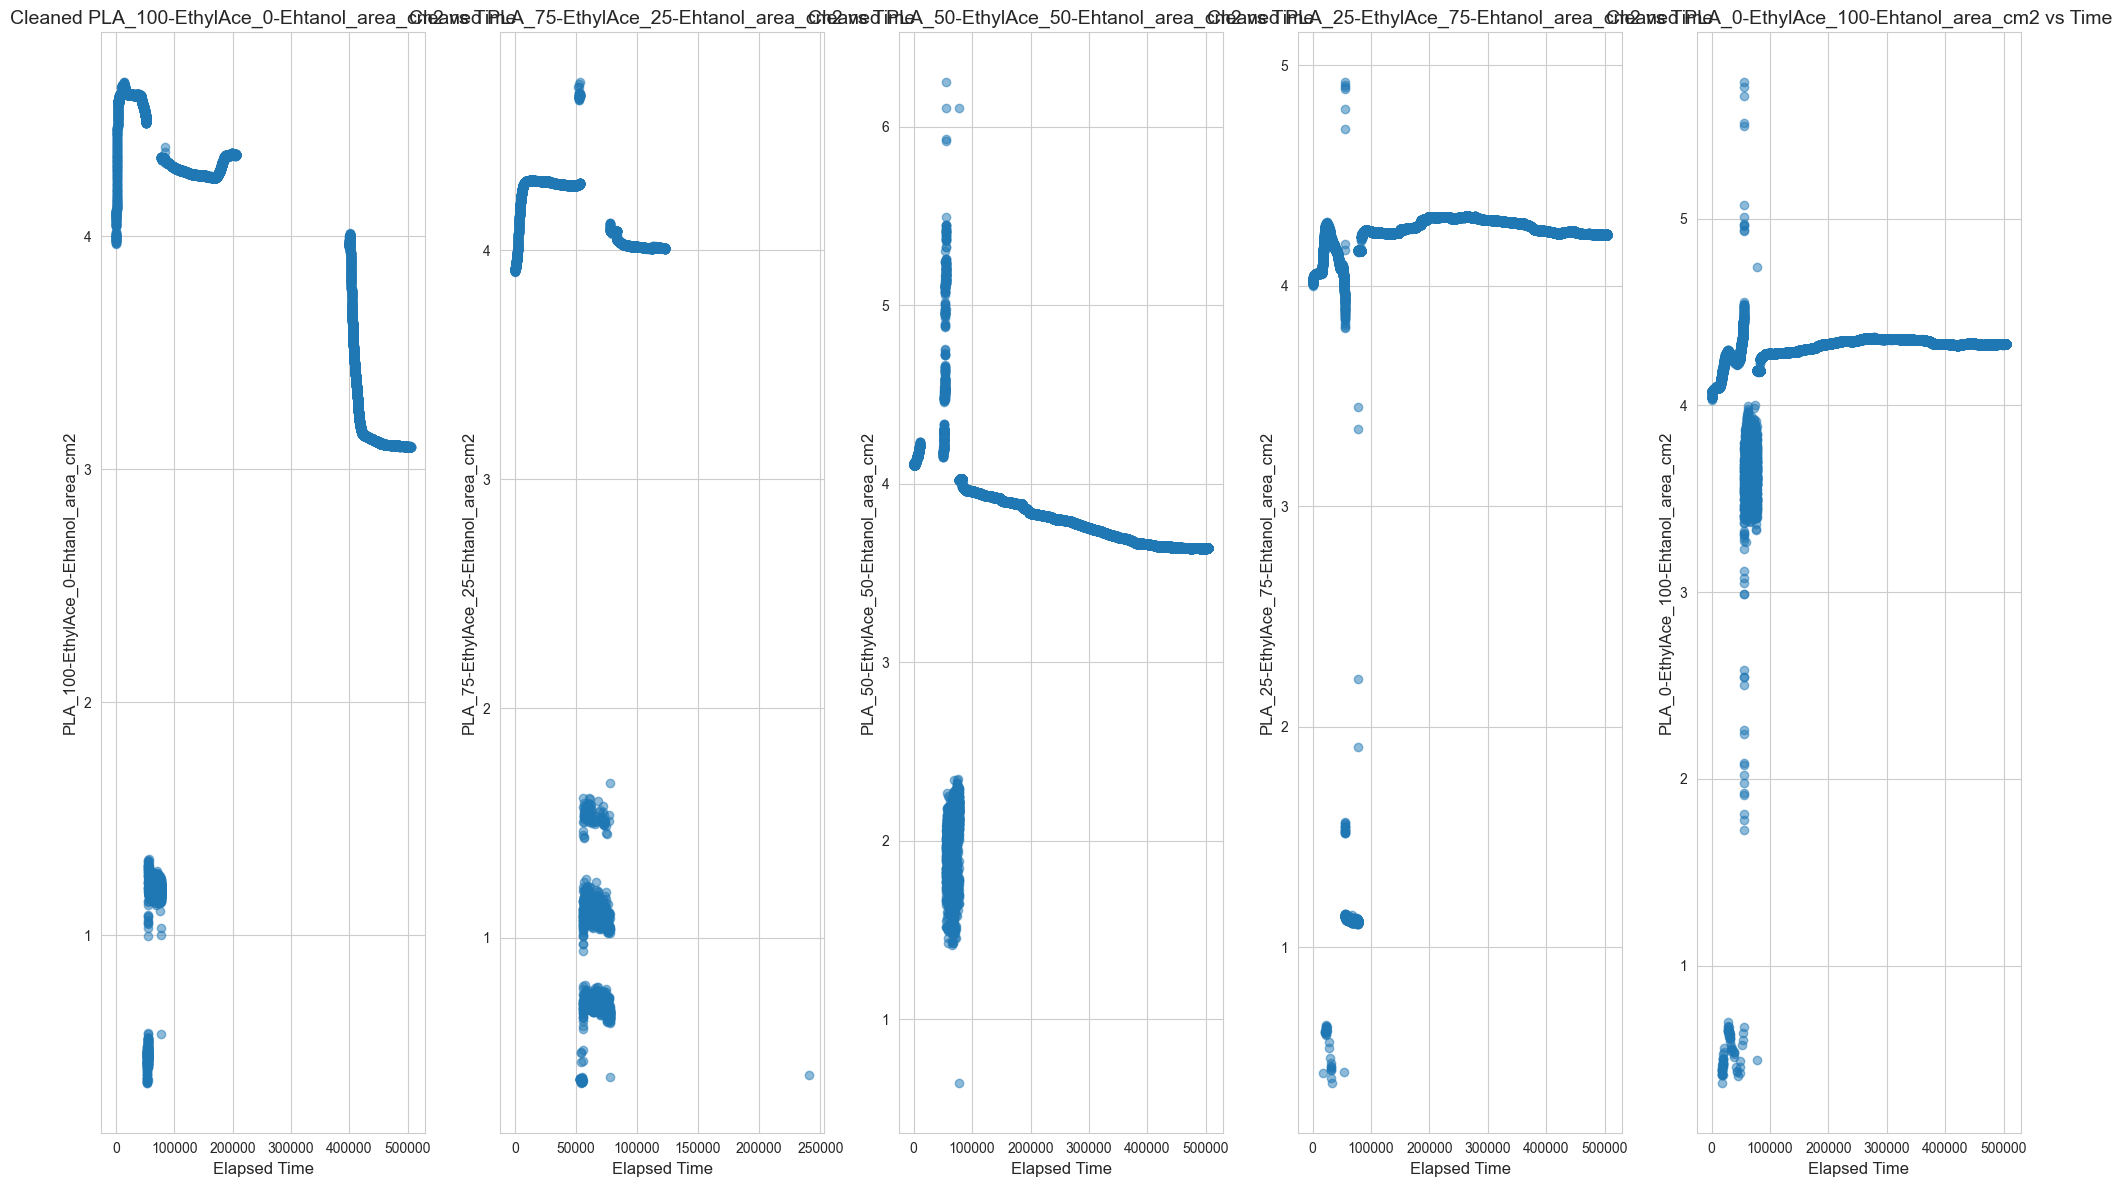

In [16]:
# 1. Remove rows where both time and area are 0
# Assuming your columns are named 'elapsed_time' and there's an area column
# You may need to adjust the column names based on your actual data
area_columns = [col for col in combined_df.columns if 'area_' in col.lower() or 'cm2' in col.lower()]

# First approach: Remove rows where ALL area columns are 0
zeros_mask = combined_df[area_columns].eq(0).all(axis=1)
df_no_zeros = combined_df[~zeros_mask].reset_index(drop=True)
print(f"\nRemoved {zeros_mask.sum()} rows where all area columns are 0 ({zeros_mask.sum()/len(combined_df)*100:.2f}% of data)")

# Convert ANY 0 values in area columns to NaN, treating each column independently
df_clean = df_no_zeros.copy()
zero_counts = {}

for area_col in area_columns:
    # Count zeros in this column before replacement
    zero_count = (df_clean[area_col] == 0).sum()
    zero_counts[area_col] = zero_count
    
    # Replace zeros with NaN in this specific column
    df_clean[area_col] = df_clean[area_col].replace(0, np.nan)

# Print summary of zero replacements
print("\nZero values replaced with NaN in each column:")
for area_col, count in zero_counts.items():
    print(f"  - {area_col}: {count} zeros replaced ({count/len(df_clean)*100:.2f}% of values)")
    
print(f"\nTotal zero values replaced with NaN: {sum(zero_counts.values())}")

# 2. Remove outliers using the IQR method for each area column
# (Your commented code for outlier removal can be uncommented if needed)
# for area_col in area_columns:
#     # Calculate Q1, Q3, and IQR
#     Q1 = df_clean[area_col].quantile(0.25)
#     Q3 = df_clean[area_col].quantile(0.75)
#     IQR = Q3 - Q1
    
#     # Define outlier bounds (typically 1.5 * IQR)
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
    
#     # Create a mask for non-outliers
#     outlier_mask = (df_clean[area_col] < lower_bound) | (df_clean[area_col] > upper_bound)
    
#     # Print information about outliers
#     outlier_count = outlier_mask.sum()
#     print(f"\nColumn {area_col}:")
#     print(f"  - Q1: {Q1:.4f}, Q3: {Q3:.4f}, IQR: {IQR:.4f}")
#     print(f"  - Lower bound: {lower_bound:.4f}, Upper bound: {upper_bound:.4f}")
#     print(f"  - Outliers detected: {outlier_count} ({outlier_count/len(df_clean)*100:.2f}%)")
    
#     # Remove outliers
#     df_clean = df_clean[~outlier_mask].reset_index(drop=True)


# Final results
print("\nFinal data shape after removing zeros and replacing with NaN:", df_clean.shape)
print("Removed a total of", combined_df.shape[0] - df_clean.shape[0], "rows")

# Visualize the cleaned data
plt.figure(figsize=(20, 12))
for i, area_col in enumerate(area_columns):
    plt.subplot(1, len(area_columns), i+1)
    plt.scatter(df_clean['elapsed_time'], df_clean[area_col], alpha=0.5)
    plt.title(f'Cleaned {area_col} vs Time')
    plt.xlabel('Elapsed Time')
    plt.ylabel(area_col)

plt.tight_layout()
plt.show()









## Nicer Graphs


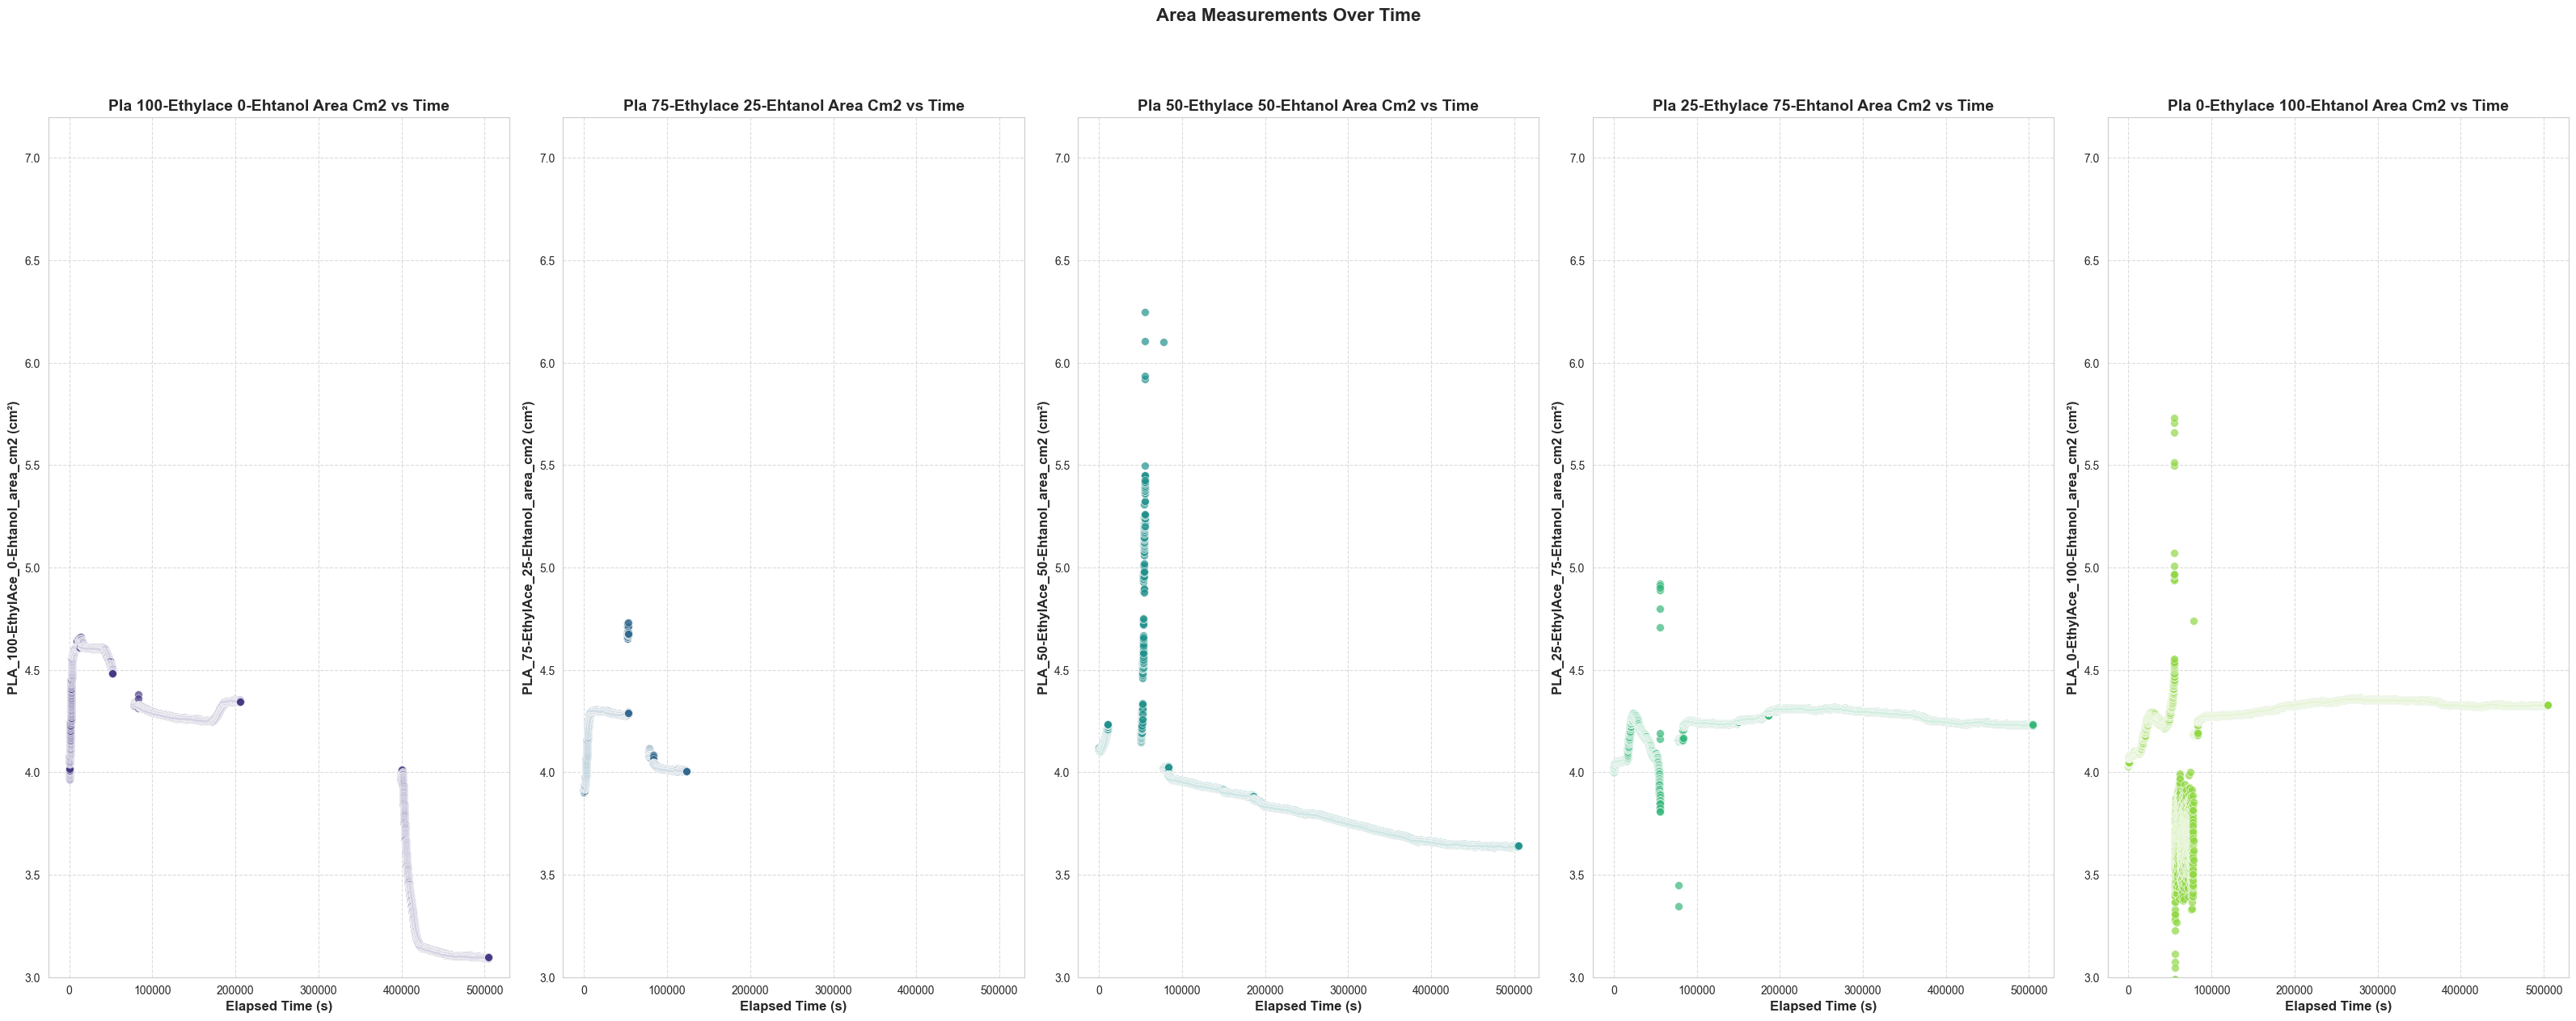


Enhanced visualization saved as 'area_time_analysis.png'


In [17]:
# Set the style for a more modern look
sns.set_style("whitegrid")
plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (14, 8)
})

# Create a color palette
colors = sns.color_palette("viridis", len(area_columns))

# Create the figure with subplots
fig, axes = plt.subplots(1, len(area_columns), figsize=(32, 12))
if len(area_columns) == 1:
    axes = [axes]  # Make axes iterable if there's only one subplot

# Plot each area column
for i, (area_col, ax, color) in enumerate(zip(area_columns, axes, colors)):
    # Create scatter plot with improved styling
    scatter = ax.scatter(
        df_clean['elapsed_time'], 
        df_clean[area_col],
        alpha=0.7,
        s=50,  # Slightly larger point size
        edgecolor='w',  # White edge for better visibility
        linewidth=0.5,
        c=[color],  # Use the color from our palette
    )
    
    # Improve titles and labels
    ax.set_title(f'{area_col.replace("_", " ").title()} vs Time', fontweight='bold')
    ax.set_xlabel('Elapsed Time (s)', fontweight='bold')
    ax.set_ylabel(f'{area_col} (cm²)', fontweight='bold')
    
    # Add grid for better readability
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Improve axis limits with some padding
    x_min, x_max = df_clean['elapsed_time'].min(), df_clean['elapsed_time'].max()
    x_padding = (x_max - x_min) * 0.05
    
    # Set fixed y-limits from 3.5 to 4.5 as requested
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(3.0, 7.2)

# Add a main title for the entire figure
fig.suptitle('Area Measurements Over Time', fontsize=16, fontweight='bold', y=1.05)

# Adjust layout to prevent overlapping
plt.tight_layout()

# # Add a text annotation with statistics
# for i, (area_col, ax) in enumerate(zip(area_columns, axes)):
#     stats_text = (
#         f"Statistics for {area_col}:\n"
#         f"Mean: {df_clean[area_col].mean():.3f} cm²\n"
#         f"Min: {df_clean[area_col].min():.3f} cm²\n"
#         f"Max: {df_clean[area_col].max():.3f} cm²"
#     )
#     ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, 
#             fontsize=9, verticalalignment='top', 
#             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Save the figure with high resolution
plt.savefig("area_time_analysis.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

print("\nEnhanced visualization saved as 'area_time_analysis.png'")